In [1]:
import mdai
mdai.__version__
import numpy as np
import skimage
from skimage import io, img_as_float, exposure
import skimage.exposure as ex 
from skimage.transform import resize
import scipy.ndimage as ndi 
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import math

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Input, layers
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as InceptionV3_Preprocess
from tensorflow.keras.applications.xception import preprocess_input as Xception_Preprocess

In [2]:
from scikeras.wrappers import KerasClassifier

In [3]:
import sklearn

In [4]:
categories = ['atypical', 'indeterminate', 'negative', 'typical']
train_image_arrays = np.load('train_image_arrays.npy', allow_pickle = True)
test_image_arrays = np.load('test_image_arrays.npy', allow_pickle = True)
train_labels = np.load('train_labels.npy', allow_pickle = True)
test_labels = np.load('test_labels.npy', allow_pickle = True)

In [5]:
def tl_Model(input_shape):
    print(input_shape)
    model_inceptionv3 = InceptionV3(weights = 'imagenet', include_top = False, input_shape = input_shape, pooling = 'avg')
    model = Sequential([
        model_inceptionv3,
        Dense(672, activation = 'relu', name = 'Dense_1'),
        Dropout(0.2),
        Dense(320, activation = 'relu', name = 'Dense_2'),
        Dropout(0.2),
        Dense(48, activation = 'relu', name = 'Dense_3'),
        Dropout(0.2),
        Dense(4, activation = 'softmax')
    ])
    model.layers[0].trainable = False
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

In [6]:
desired_input_shape = train_image_arrays[0].shape
model_TL = tl_Model(desired_input_shape)

model_TL.summary()

(299, 299, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 Dense_1 (Dense)             (None, 672)               1376928   
                                                                 
 dropout (Dropout)           (None, 672)               0         
                                                                 
 Dense_2 (Dense)             (None, 320)               215360    
                                                                 
 dropout_1 (Dropout)         (None, 320)               0         
                                                                 
 Dense_3 (Dense)             (None, 48)                15408     
                                                                 
 dropout_2 (Dropout)         (None, 48)   

In [7]:
def get_preprocessed_input():
    '''
    Pre-processes the 15-SCENE data using Resnet50 preprocessing function.
    
    Returns the tupple of pre-processed training and test data.
    '''
    ### BEGIN SOLUTION
    # x_train_inception = preprocess_input(train_image_arrays)
    # x_test_inception  = preprocess_input(test_image_arrays)
    #Model X
    x_train_inception = InceptionV3_Preprocess(train_image_arrays)
    x_test_inception = InceptionV3_Preprocess(test_image_arrays)
    
    
    return (x_train_inception, x_test_inception)

In [8]:
train_image_inception, test_image_inception = get_preprocessed_input()


In [9]:
reduce_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,mode='auto', min_delta=0.00001, cooldown=0, min_lr=0,)
checkpoint_best_only = ModelCheckpoint(filepath = 'checkpoints_best_only/checkpoint', save_best_only=True, monitor='val_accuracy', save_weights_only=True,  verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 3, mode = 'max', verbose = 1)
new_history = model_TL.fit(train_image_inception, train_labels, epochs=50, validation_data=(test_image_inception, test_labels), callbacks=[early_stopping, checkpoint_best_only, reduce_loss])

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 1.4301 - accuracy: 0.3032
Epoch 1: val_accuracy improved from -inf to 0.39326, saving model to checkpoints_best_only\checkpoint
24/24 [==============================] - 14s 241ms/step - loss: 1.4301 - accuracy: 0.3032 - val_loss: 1.3116 - val_accuracy: 0.3933 - lr: 1.0000e-04
Epoch 2/50
23/24 [===========================>..] - ETA: 0s - loss: 1.3261 - accuracy: 0.3641
Epoch 2: val_accuracy did not improve from 0.39326
24/24 [==============================] - 2s 88ms/step - loss: 1.3255 - accuracy: 0.3644 - val_loss: 1.3098 - val_accuracy: 0.3427 - lr: 1.0000e-04
Epoch 3/50
23/24 [===========================>..] - ETA: 0s - loss: 1.3074 - accuracy: 0.3940
Epoch 3: val_accuracy did not improve from 0.39326
24/24 [==============================] - 2s 89ms/step - loss: 1.3070 - accuracy: 0.3936 - val_loss: 1.3100 - val_accuracy: 0.3652 - lr: 1.0000e-04
Epoch 4/50
23/24 [===========================>..] - ETA: 0s - loss: 1.2

In [12]:
#Define functions to plot accuracy and loss
def plotAccuracy(history):

    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 
    
def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 


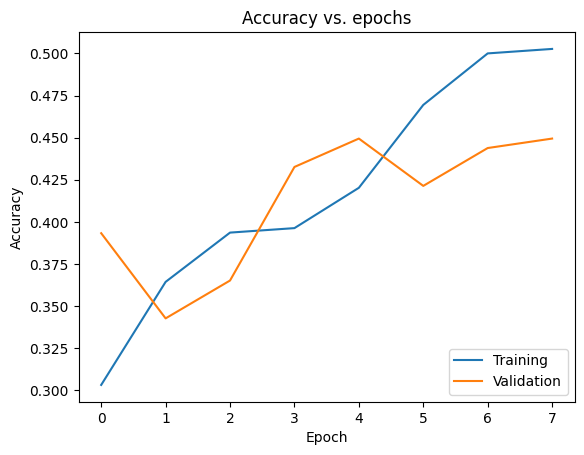

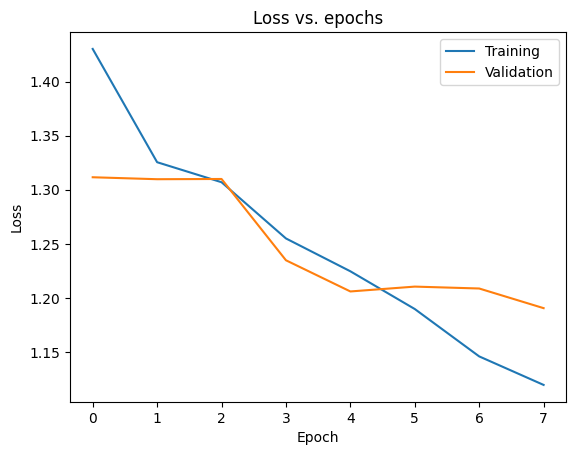

In [13]:
plotAccuracy(new_history)
plotLoss(new_history)


In [14]:
def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc= model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    return test_acc

In [15]:
print("Test:")
test_first = get_test_accuracy(model_TL, test_image_inception, test_labels)
print("Train:")
train_first = get_test_accuracy(model_TL, train_image_inception, train_labels)

Test:
accuracy: 0.449
Train:
accuracy: 0.632


In [16]:
def confMat(model, x_test, y_test):
    plt.figure(figsize=(15, 5))

    #Predict test images
    predict_x = model.predict(x_test)
    #Get corresponding predicted label
    y_pred=np.argmax(predict_x,axis=1)

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=categories, columns=categories)

    plt.title("Confusion matrix\n")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.show()

6/6 [==============================] - 2s 76ms/step


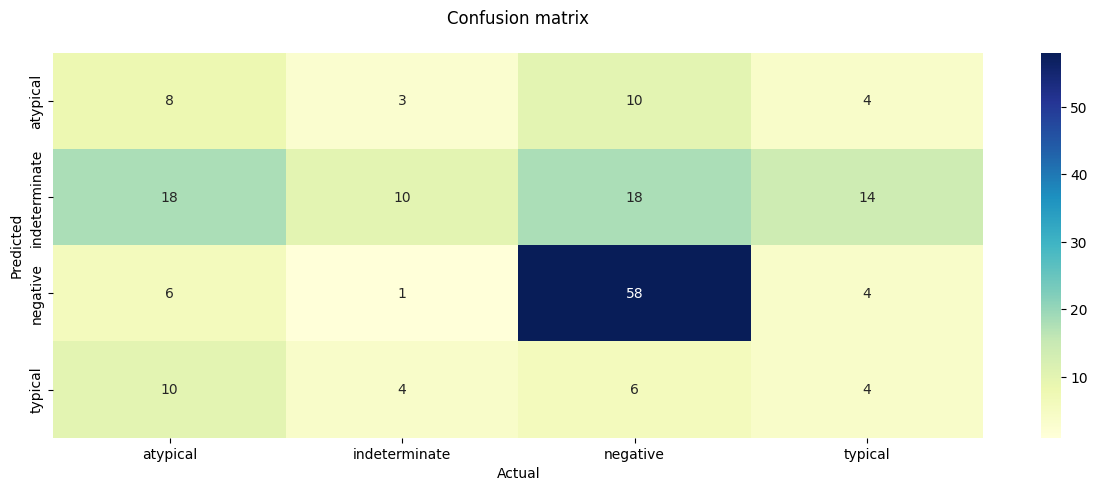

In [17]:
confMat(model_TL, test_image_inception, test_labels)